In [1]:
import numpy as np
import theano
from theano import tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from logistic_sgd import load_data
from utils import tile_raster_images
import time
import PIL.Image as Image

In [46]:
class DA(object):
    
    def __init__(self,numpy_rng,theano_rng,input=None,n_visible=784,n_hidden=500,W=None,bhid=None,bvis=None):
        
        ## bhid : bias values for hidden units
        ## bvis : bias values for visible units
        
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        
        if theano_rng is None:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))
        
        
        if not W:
            inital_W = np.asarray(
                            numpy_rng.uniform(
                                low = -4 * np.sqrt(6. / (n_visible + n_hidden)),
                                high = 4 * np.sqrt(6. / (n_visible + n_hidden)),
                                size = (n_visible,n_hidden)
                            ),dtype = theano.config.floatX
                        )
        Weight = theano.shared(value = inital_W, name = 'W',borrow = True)
        
        if not bvis:
            bvis = theano.shared(
                        value = np.zeros((n_visible,) , dtype = theano.config.floatX),
                        borrow = True
                    )
        
        if not bhid:
            bhid = theano.shared(
                        value = np.zeros((n_hidden,), dtype = theano.config.floatX),
                        borrow = True,
                        name = 'b'
                    )
        
        self.W = Weight
        self.b = bhid
        self.b_prime = bvis
        self.W_prime = self.W.T
        self.theano_rng = theano_rng
        
        if input is None:
            self.x = T.dmatrix(name='input')
        else:
            self.x = input
        
        self.params = [self.W , self.b , self.b_prime] ## save the parameter of model
    
    
    def get_corrupted_input(self,input,corruption_level):
        
        return self.theano_rng.binomial(size = input.shape, n =1 ,
                                   p = 1 - corruption_level,
                                   dtype = theano.config.floatX) * input
    
    def get_hidden_values(self,input):
        
        return T.nnet.sigmoid(T.dot(input,self.W) + self.b)
    
    def get_reconstructed_values(self,hidden):
        
        return T.nnet.sigmoid(T.dot(hidden,self.W_prime) + self.b_prime)
    
    def get_cost_updates(self,corruption_level, learning_rate):
        
        x = self.get_corrupted_input(self.x,corruption_level)
        y = self.get_hidden_values(x)
        z = self.get_reconstructed_values(y)
        
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
    
        cost = T.mean(L)
        
        ## gradient descent
        gparams = T.grad(cost,self.params)
        ## generate updates
        updates = [(param, param - learning_rate * gparam) for param,gparam in zip(self.params , gparams)]
        
        return (cost,updates)

In [50]:
def test(learning_rate = 0.1 , training_epoch  =15, batch_size = 20):
    
    datasets = load_data()
    train_x,train_y = datasets[0]
    
    ## compute the number of minibatches
    n_train_batches = train_x.get_value(borrow=True).shape[0] // batch_size
    
    index = T.lscalar() ## minibatch index 
    x = T.matrix('x')
    
    rng = np.random.RandomState(42)
    theano_rng = RandomStreams(rng.randint(2 **30))
    
    da = DA(numpy_rng = rng,theano_rng = theano_rng ,
            input = x , n_visible=28*28,n_hidden=500 )
    
    cost,updates = da.get_cost_updates(corruption_level = 0, learning_rate =learning_rate)
    
    train_da = theano.function(
        inputs = [index],
        outputs = cost,
        updates=updates,
        givens={
            x: train_x[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    start_time = time.time()
    
    for epoch in xrange(training_epoch):
        result = []
        for minibatch_index in xrange(n_train_batches):
            result.append(train_da(minibatch_index))
        print '%i epoch , cost %f' % (epoch , np.mean(result))
        
    end_time = time.time()
    image = Image.fromarray(
                tile_raster_images(
                    X= da.W.get_value(borrow=True).T,
                    img_shape = (28,28),
                    tile_shape =(10,10),
                    tile_spacing = (1,1)
                )
            )
    print 'Time is %0.2f' %((end_time - start_time ) / 60)
    return image

Loading data....
0 epoch , cost 63.181069
1 epoch , cost 55.801855
2 epoch , cost 54.794815
3 epoch , cost 54.284706
4 epoch , cost 53.938544
5 epoch , cost 53.674547
6 epoch , cost 53.460512
7 epoch , cost 53.280479
8 epoch , cost 53.125558
9 epoch , cost 52.990412
10 epoch , cost 52.871161
11 epoch , cost 52.764716
12 epoch , cost 52.668631
13 epoch , cost 52.581038
14 epoch , cost 52.500639
Time is 2.79


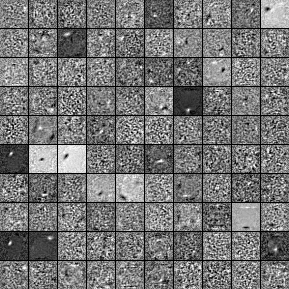

In [51]:
test()